# <font color='blue'> Data Sprint HDB Resale Prices </font>

Group 4: Ameer, Benjamin, Leonard, Wei Yu.

# Exploring data:

In [520]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import iqr

%matplotlib inline

In [521]:
hdb = pd.read_csv('./datasets/train.csv')

hdb.head()

C:\Users\benwr\AppData\Local\Temp\ipykernel_13008\3995983073.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb = pd.read_csv('./datasets/train.csv')


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,...,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,...,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,...,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


In [522]:
print(f"{hdb.shape[0]} rows and {hdb.shape[1]} columns")

150634 rows and 78 columns


150634 rows & 78 columns

# Checking for duplicates by id column

In [523]:
hdb['id'].value_counts().sort_values(ascending=False)

id
88471     1
122598    1
170897    1
86070     1
153632    1
         ..
39814     1
147177    1
179087    1
21309     1
185947    1
Name: count, Length: 150634, dtype: int64

# Dropping columns that won't be included after inspecting Data dict

In [524]:
hdb = hdb.drop(columns=['block', 'address', 'lower', 'upper', 'mid', 'full_flat_type', 'floor_area_sqft', 'lease_commence_date', 'year_completed', 
                  'postal', 'Mall_Within_500m', 'Mall_Within_1km', 'Mall_Within_2km', 'Hawker_Within_500m', 'Hawker_Within_1km', 
                  'Hawker_Within_2km', 'mrt_name', 'mrt_latitude', 'mrt_longitude', 'bus_stop_name', 'bus_stop_latitude', 'bus_stop_longitude',
                  'pri_sch_name', 'vacancy', 'pri_sch_latitude', 'pri_sch_longitude', 'sec_sch_name', 'affiliation', 'sec_sch_latitude', 
                  'sec_sch_longitude', 'planning_area', 'residential', 'market_hawker'])

# Checking for NAs

In [525]:
hdb.isna().sum().sort_values(ascending=False).head()

Mall_Nearest_Distance    829
Tranc_YearMonth            0
town                       0
flat_type                  0
id                         0
dtype: int64

Imputing for NAs under Mall_nearest_distance

In [526]:
mean_nearest_mall = hdb.groupby('town')['Mall_Nearest_Distance'].mean()

mean_nearest_mall = mean_nearest_mall.reset_index()

In [527]:
hdb = pd.merge(hdb, mean_nearest_mall, how='left', on='town')

In [528]:
hdb.head()

,id,Tranc_YearMonth,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,resale_price,Tranc_Year,...,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,Mall_Nearest_Distance_y
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,UPP BOON KENG RD,10 TO 12,90.0,Model A,680000.0,2016,...,60,330.083069,0,0,29.427395,1138.633422,1,1138.633422,224,901.945072
1,122598,2012-07,BISHAN,5 ROOM,BISHAN ST 13,07 TO 09,130.0,Improved,665000.0,2012,...,77,903.659703,1,1,58.207761,415.607357,1,447.894399,232,757.967159
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,BT BATOK ST 25,13 TO 15,144.0,Apartment,838000.0,2013,...,95,1334.251197,1,0,214.747860,498.849039,0,180.074558,188,915.499125
3,86070,2012-04,BISHAN,4 ROOM,BISHAN ST 22,01 TO 05,103.0,Model A,550000.0,2012,...,86,907.453484,1,1,43.396521,389.515528,1,389.515528,253,757.967159
4,153632,2017-12,YISHUN,4 ROOM,YISHUN ST 81,01 TO 03,83.0,Simplified,298000.0,2017,...,0,412.343032,0,0,129.422752,401.200584,0,312.025435,208,619.459242


In [529]:
hdb['Mall_Nearest_Distance_x'] = hdb['Mall_Nearest_Distance_x'].fillna(hdb['Mall_Nearest_Distance_y'])

In [530]:
hdb = hdb.drop(columns='Mall_Nearest_Distance_y')

In [531]:
hdb.isnull().sum().sort_values(ascending=False).head()

id                 0
Tranc_YearMonth    0
town               0
flat_type          0
street_name        0
dtype: int64

# Checking datatypes

In [532]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   street_name                150634 non-null  object 
 5   storey_range               150634 non-null  object 
 6   floor_area_sqm             150634 non-null  float64
 7   flat_model                 150634 non-null  object 
 8   resale_price               150634 non-null  float64
 9   Tranc_Year                 150634 non-null  int64  
 10  Tranc_Month                150634 non-null  int64  
 11  mid_storey                 150634 non-null  int64  
 12  price_per_sqft             150634 non-null  float64
 13  hdb_age                    15

In [533]:
hdb['Tranc_YearMonth'] = pd.to_datetime(hdb['Tranc_YearMonth'], infer_datetime_format=True)

C:\Users\benwr\AppData\Local\Temp\ipykernel_13008\4027540773.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  hdb['Tranc_YearMonth'] = pd.to_datetime(hdb['Tranc_YearMonth'], infer_datetime_format=True)


In [534]:
hdb = hdb.astype({'floor_area_sqm':'int'})

In [535]:
# commercial
# multistorey_carpark
# precinct_pavilion

# These 3 columns have 'Y' & 'N' values. We change them to 1's & 0's. 

hdb['commercial'] = hdb['commercial'].map({'Y': 1, 'N' : 0})

hdb['multistorey_carpark'] = hdb['multistorey_carpark'].map({'Y': 1, 'N' : 0})

hdb['precinct_pavilion'] = hdb['precinct_pavilion'].map({'Y': 1, 'N' : 0})

In [536]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         150634 non-null  int64         
 1   Tranc_YearMonth            150634 non-null  datetime64[ns]
 2   town                       150634 non-null  object        
 3   flat_type                  150634 non-null  object        
 4   street_name                150634 non-null  object        
 5   storey_range               150634 non-null  object        
 6   floor_area_sqm             150634 non-null  int64         
 7   flat_model                 150634 non-null  object        
 8   resale_price               150634 non-null  float64       
 9   Tranc_Year                 150634 non-null  int64         
 10  Tranc_Month                150634 non-null  int64         
 11  mid_storey                 150634 non-null  int64   

# Handling outliers:

In [537]:
qr = []
col_data = hdb.columns[[6, 8, 9, 11, 12, 13, 14, 33, 34, 35, 36, 37, 40, 41, 43]]

for x in col_data:
    col_values = hdb[x]
    iqrc = iqr(col_values)
    lower_threshold = np.quantile(col_values, 0.25) - 1.5 * iqrc
    upper_threshold = np.quantile(col_values, 0.75) + 1.5 * iqrc
    qr.append((x, lower_threshold, upper_threshold))

print(qr)

[('floor_area_sqm', np.float64(19.5), np.float64(167.5)), ('resale_price', np.float64(87500.0), np.float64(779500.0)), ('Tranc_Year', np.float64(2006.5), np.float64(2026.5)), ('mid_storey', np.float64(-4.0), np.float64(20.0)), ('price_per_sqft', np.float64(201.34884637564792), np.float64(637.6804322009804)), ('hdb_age', np.float64(-5.5), np.float64(62.5)), ('max_floor_lvl', np.float64(6.0), np.float64(22.0)), ('Mall_Nearest_Distance_x', np.float64(-322.1303121125), np.float64(1582.0513905875)), ('Hawker_Nearest_Distance', np.float64(-1588.0928485000002), np.float64(3639.1744755)), ('hawker_food_stalls', np.float64(10.0), np.float64(90.0)), ('hawker_market_stalls', np.float64(-148.5), np.float64(247.5)), ('mrt_nearest_distance', np.float64(-317.9355169727911), np.float64(1751.935997825704)), ('bus_stop_nearest_distance', np.float64(-32.39738682939844), np.float64(254.0822865370127)), ('pri_sch_nearest_distance', np.float64(-185.56116819648815), np.float64(914.823716293168)), ('sec_sch_n

In [538]:
for col, lower, upper in qr:
    hdb = hdb[(hdb[col] >= lower) & (hdb[col] <= upper)]

In [539]:
hdb.shape

(103104, 45)

# <font color='blue'> EOD1 cleaning numbers: Rows 103104, Columns 45

# Inspecting spread/distribution using .hist & value_counts/describe

# <font color='green'> 10 columns to consider for deletion: 

# multistorey_carpark,  precinct_pavilion, 1room_sold, 2room_sold, multigen_sold, studio_apartment_sold, 1room_rental, 2room_rental, 3room_rental, other_room_rental, 

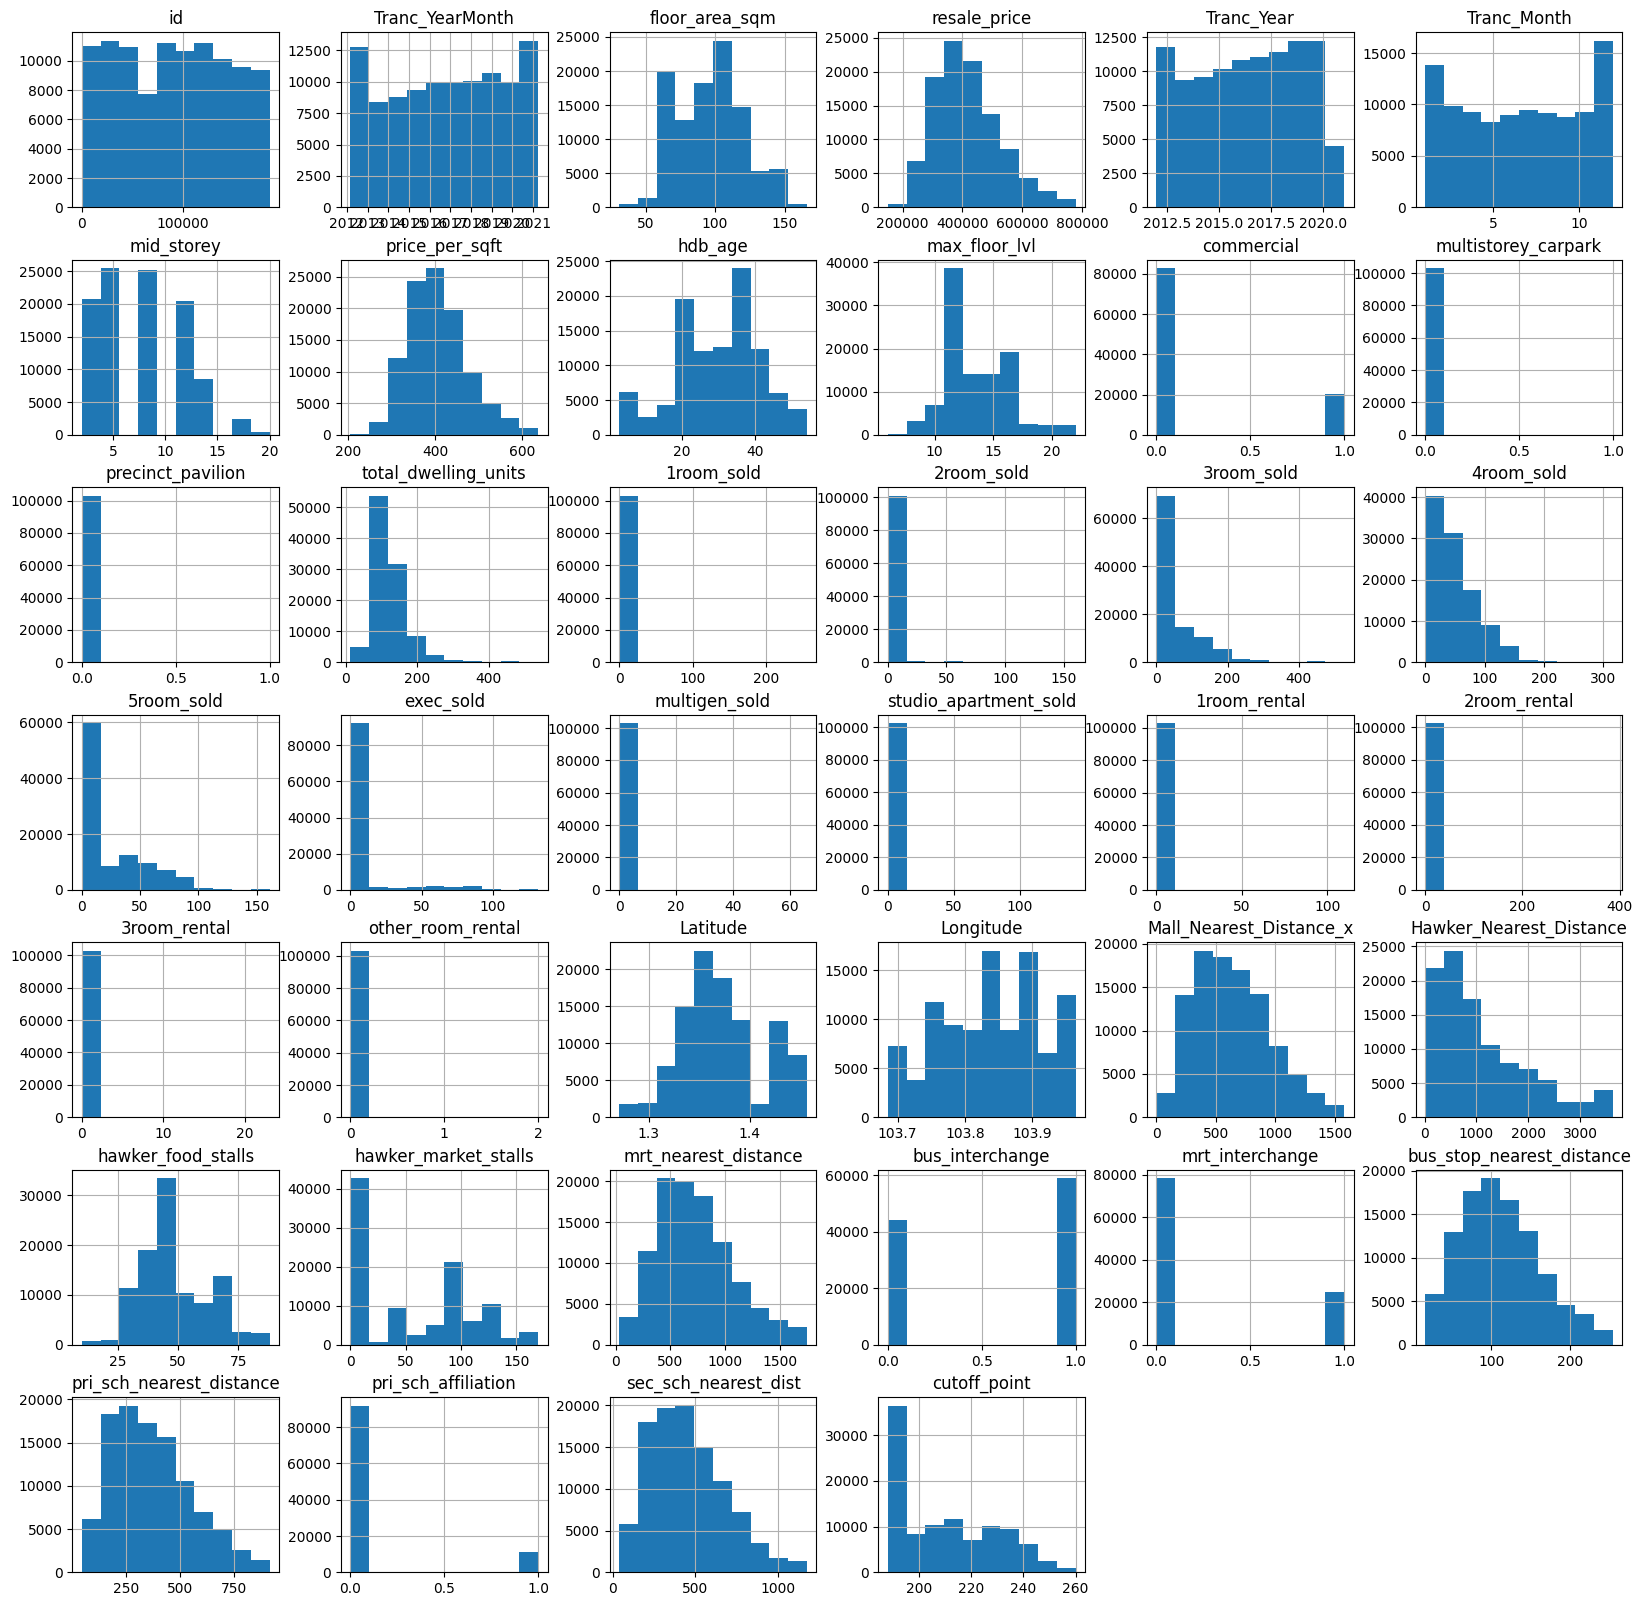

In [540]:
hdb.hist(figsize=(20,20));

In [548]:
hdb['multistorey_carpark'].value_counts()

multistorey_carpark
0    103069
1        35
Name: count, dtype: int64

In [549]:
hdb['precinct_pavilion'].value_counts()

precinct_pavilion
0    103045
1        59
Name: count, dtype: int64

In [550]:
hdb['1room_sold'].value_counts()

1room_sold
0      103059
255        45
Name: count, dtype: int64

In [551]:
hdb['2room_sold'].value_counts()

2room_sold
0     99717
10      218
9       211
59      159
1       154
      ...  
19        5
33        5
24        4
6         3
23        1
Name: count, Length: 79, dtype: int64

In [552]:
hdb['multigen_sold'].value_counts()

multigen_sold
0     103054
66        18
22        13
20         9
45         6
50         4
Name: count, dtype: int64

In [553]:
hdb['studio_apartment_sold'].value_counts()

studio_apartment_sold
0      102556
21         46
36         39
43         29
75         28
38         26
52         25
131        24
65         23
25         23
41         21
23         20
33         19
39         19
132        15
87         15
28         14
45         13
79         13
50         12
37         11
101        11
123        10
92         10
97          9
55          9
85          8
122         8
71          8
82          7
74          7
77          5
76          5
142         4
44          4
80          4
48          2
11          1
29          1
Name: count, dtype: int64

In [554]:
hdb['1room_rental'].value_counts()

1room_rental
0      102862
16         72
20         57
5          45
110        18
84         16
48         15
91         13
36          5
10          1
Name: count, dtype: int64

In [555]:
hdb['2room_rental'].value_counts()

2room_rental
0      101774
1         300
3         137
2         128
4          99
16         72
20         58
5          51
63         33
89         32
271        30
117        26
139        25
126        23
77         19
70         19
102        19
254        18
180        17
74         17
68         16
386        15
101        14
109        14
15         13
91         12
133        12
45         11
157        11
138        10
58         10
113        10
48         10
134         8
42          8
41          8
64          7
128         7
78          6
57          5
Name: count, dtype: int64

In [556]:
hdb['3room_rental'].value_counts()

3room_rental
0     100315
1       2072
2        357
3        158
7        108
12        37
14        24
5         18
4         14
23         1
Name: count, dtype: int64

In [557]:
hdb['other_room_rental'].value_counts()

other_room_rental
0    103095
2         9
Name: count, dtype: int64